### ML Modeling for Housing Price Prediction

#### Author: Vivek Pandey

Note: The data engineering and eda notebooks need to be run before running this, since it expects certain outputs generated by those notebooks

In [32]:
# Dependency imports
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Notebook customizations
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1
import warnings
warnings.filterwarnings('ignore')

In [33]:
def heatMap(df, mirror):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(15, 6))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

In [34]:
transactions_master_df = pd.read_csv('./output/post_eda_transactions_master.csv', sep='|', \
                                     dtype={'zip_code': str}, encoding='latin1')
transactions_master_df.head()

,document_type,price,property_url,transaction_type,recording_year,recording_month,recording_day,contract_year,contract_month,contract_day,address,area_sqft,built_year,city,lot_size,no_of_baths,no_of_bedrooms,property_type,state,tax_amount,tax_year,zip_code
0,Deed,224000.0,https://www.trulia.com/p/ny/holmes/10-cliff-ct-holmes-ny-12531--2305202587,Purchase/Resale Arm's Length Residential Transaction,2001,7,30,2001,6,25,10 Cliff Ct,1184.0,1997,Holmes,60984.0,2.5,3.0,Single-Family Home,NY,8320.40,2017,12531
1,Deed,417500.0,https://www.trulia.com/p/ny/craryville/311-taghkanic-churchtown-rd-craryville-ny-12521--2158455139,Purchase/Resale Arm's Length Residential Transaction,2005,7,25,2005,7,22,311 Taghkanic Churchtown Rd,1872.0,1990,Craryville,198198.0,1.0,4.0,Single-Family Home,NY,7563.77,2017,12521
2,Deed,32000.0,https://www.trulia.com/p/ny/craryville/12-taghkanic-churchtown-rd-craryville-ny-12521--2158455187,Insured Non-Residential Grant Deed,1996,10,18,1996,9,10,12 Taghkanic Churchtown Rd,1708.0,1998,Craryville,274428.0,1.0,2.0,Single-Family Home,NY,5769.40,2017,12521
3,Deed,235000.0,https://www.trulia.com/p/ny/craryville/11-taghkanic-churchtown-rd-craryville-ny-12521--1100838069,Purchase/Resale Arm's Length Residential Transaction,2016,10,25,2016,10,25,11 Taghkanic Churchtown Rd,1728.0,2007,Craryville,249163.2,2.5,3.0,Single-Family Home,NY,5270.54,2017,12521
4,Deed,15300.0,https://www.trulia.com/p/ny/craryville/12-taghkanic-churchtown-rd-craryville-ny-12521--2158455186,Insured Non-Residential Grant Deed,1994,6,3,1994,6,1,12 Taghkanic Churchtown Rd,1952.0,1996,Craryville,222591.6,1.5,3.0,Single-Family Home,NY,6896.60,2017,12521


In [35]:
transactions_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226349 entries, 0 to 226348
Data columns (total 22 columns):
document_type       226349 non-null object
price               226349 non-null float64
property_url        226349 non-null object
transaction_type    226349 non-null object
recording_year      226349 non-null int64
recording_month     226349 non-null int64
recording_day       226349 non-null int64
contract_year       226349 non-null int64
contract_month      226349 non-null int64
contract_day        226349 non-null int64
address             226349 non-null object
area_sqft           226349 non-null float64
built_year          226349 non-null int64
city                226349 non-null object
lot_size            226349 non-null float64
no_of_baths         226349 non-null float64
no_of_bedrooms      226349 non-null float64
property_type       226349 non-null object
state               226349 non-null object
tax_amount          226349 non-null float64
tax_year            226349 non

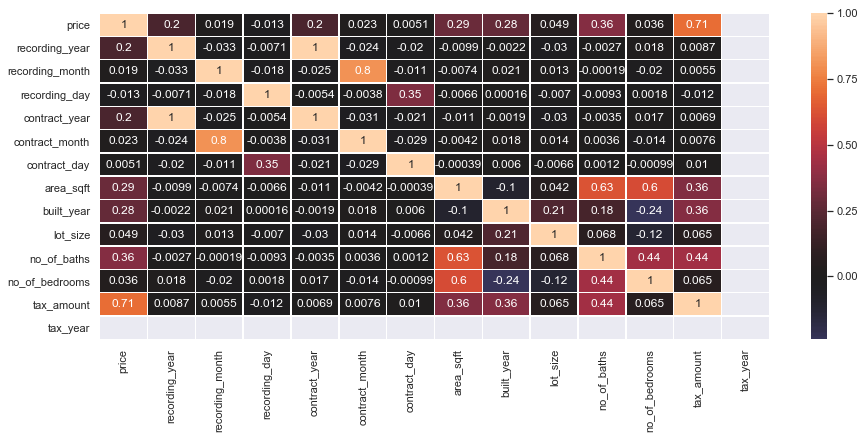

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(data=transactions_master_df.corr(), linewidths=0.5, center=0, annot=True, ax=ax)

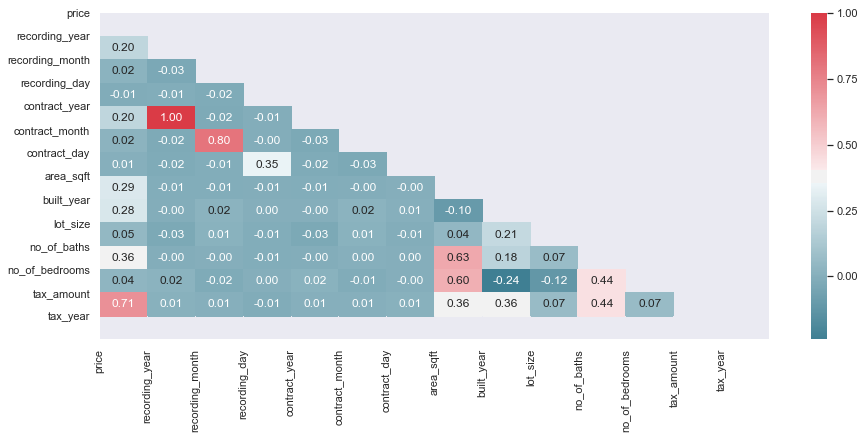

In [37]:
heatMap(transactions_master_df, False)

#### Dropping highly correlated fields and other useless fields

In [38]:
transactions_master_df = transactions_master_df.drop(columns=['contract_year', 'contract_month', 'tax_year'], axis=1)
transactions_master_df = transactions_master_df.drop(columns=['property_url', 'address', 'state'], axis=1)
transactions_master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226349 entries, 0 to 226348
Data columns (total 16 columns):
document_type       226349 non-null object
price               226349 non-null float64
transaction_type    226349 non-null object
recording_year      226349 non-null int64
recording_month     226349 non-null int64
recording_day       226349 non-null int64
contract_day        226349 non-null int64
area_sqft           226349 non-null float64
built_year          226349 non-null int64
city                226349 non-null object
lot_size            226349 non-null float64
no_of_baths         226349 non-null float64
no_of_bedrooms      226349 non-null float64
property_type       226349 non-null object
tax_amount          226349 non-null float64
zip_code            226349 non-null object
dtypes: float64(6), int64(5), object(5)
memory usage: 27.6+ MB


In [39]:
print(transactions_master_df['transaction_type'].nunique())
print(transactions_master_df['property_type'].nunique())
print(transactions_master_df['document_type'].nunique())
print(transactions_master_df['city'].nunique())
print(transactions_master_df['zip_code'].nunique())

5
8
40
467
435


In [40]:
print(transactions_master_df['document_type'].value_counts())
print(transactions_master_df['transaction_type'].value_counts())
print(transactions_master_df['property_type'].value_counts())

Deed                                                                                                                                                                                                                    138160
Warranty Deed                                                                                                                                                                                                           44603 
Bargain and Sale Deed                                                                                                                                                                                                   9490  
REO Resale                                                                                                                                                                                                              8288  
Land Contract                                                                                               

### ML Pipeline

#### Performing one hot encoding, and normalizing the data if necessary

In [41]:
transactions_master_df.columns

Index(['document_type', 'price', 'transaction_type', 'recording_year',
       'recording_month', 'recording_day', 'contract_day', 'area_sqft',
       'built_year', 'city', 'lot_size', 'no_of_baths', 'no_of_bedrooms',
       'property_type', 'tax_amount', 'zip_code'],
      dtype='object')

Defining features and target using the dataframe we have

In [42]:
target = transactions_master_df['price'].values
features = transactions_master_df[['document_type', 'transaction_type', 'recording_year',
       'recording_month', 'recording_day', 'contract_day', 'area_sqft',
       'built_year', 'lot_size', 'no_of_baths', 'no_of_bedrooms',
       'property_type', 'tax_amount']]
# ADD CITY AND ZIP_CODE AS WELL, RIGHT NOW THEY ARE REMOVED
features.head()

,document_type,transaction_type,recording_year,recording_month,recording_day,contract_day,area_sqft,built_year,lot_size,no_of_baths,no_of_bedrooms,property_type,tax_amount
0,Deed,Purchase/Resale Arm's Length Residential Transaction,2001,7,30,25,1184.0,1997,60984.0,2.5,3.0,Single-Family Home,8320.40
1,Deed,Purchase/Resale Arm's Length Residential Transaction,2005,7,25,22,1872.0,1990,198198.0,1.0,4.0,Single-Family Home,7563.77
2,Deed,Insured Non-Residential Grant Deed,1996,10,18,10,1708.0,1998,274428.0,1.0,2.0,Single-Family Home,5769.40
3,Deed,Purchase/Resale Arm's Length Residential Transaction,2016,10,25,25,1728.0,2007,249163.2,2.5,3.0,Single-Family Home,5270.54
4,Deed,Insured Non-Residential Grant Deed,1994,6,3,1,1952.0,1996,222591.6,1.5,3.0,Single-Family Home,6896.60


Splitting the data to train and test data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=21)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

Below we will create a ML pipeline where a series of steps will be taken in order to train the model. This pipeline will also be used in any subsequent predictions. 

The pipeline performs the following order of operations
* ColumnTransformer takes in the categorical columns and performs one hot encoding on them, using a mask for selecting the column subsets based on the dtypes
* Any standard scalers or imputers, if necessary
* Linear Regression Model for training and predictions

In [44]:
categorical_features = (features.dtypes == 'object')
numerical_features = ~categorical_features

In [45]:
categorical_features[categorical_features == True].index.tolist()

['document_type', 'transaction_type', 'property_type']

In [46]:
numerical_features

document_type       False
transaction_type    False
recording_year      True 
recording_month     True 
recording_day       True 
contract_day        True 
area_sqft           True 
built_year          True 
lot_size            True 
no_of_baths         True 
no_of_bedrooms      True 
property_type       False
tax_amount          True 
dtype: bool

### Custom Transformer

Out-of-the-box sklearn one hot encoders do not support dropping one of the columns after hot encoding, and it also creates a problem while trying to retrieve the new column set post hot encoding when there are other transformations happening. Hence this option

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features=None, reindex_columns=None):
        self.categorical_features = categorical_features
        self.reindex_columns = reindex_columns
        self.updated_feature_names = None
    
    def transform(self, X, **transformparams):
        #print (transformparams.get('arg1'))
        self.updated_feature_names = []
        hot_encoded_df = pd.get_dummies(data=X, columns=self.categorical_features, \
                                        drop_first=False).copy()
        # Lets reindex this thing, which will add any missing columns in the passed data
        print(hot_encoded_df.shape)
        hot_encoded_df = hot_encoded_df.reindex(columns=self.reindex_columns, fill_value=0)
        print(hot_encoded_df.shape)
        # Now we have reformed the encoded dataframe by filling any missing columns
        self.updated_feature_names = hot_encoded_df.columns
        return hot_encoded_df
    
    def fit(self, X, y=None, **fitparams):
        return self
    
    def get_feature_names(self):
        return self.updated_feature_names

### Preparing inputs for the encoder

The encoder needs to be provided with
* Columns to be encoded
* Exhaustive list of columns that should be generated from one hot encoding

Normally, encoders generate the second input on their own. That's actually one of the tasks of one hot encoders. The reason we are tweaking this behavior here (predetermining production needs) is because we need to merge the train and test data, find all unique values in categorical columns and provide these column names to the encoder. If we don't do this, the one hot encoder will only generate hot encoded columns off of train data. This will create issues if your test/validation data has different set of unique values in one of the categorical columns. This will cause the preprocessor to generate a higher/lower number of columns than what the pipeline has been fitted on, hence resulting in errors. Comprende?

In [48]:
columns_to_encode = categorical_features[categorical_features == True].index.tolist()

reindex_hot_encoding = []
# Iterating through all the columns in feature set
for column in features.columns:
    # If the column name is in the columns_to_encode list, append all the unique values of that column
    if column in columns_to_encode:
        # Ignore the first unique value, we drop it in reindex list instead of using drop=True in get_dummies later
        for count, item in enumerate(features[column].unique()):
            if count is not 0:
                reindex_hot_encoding.append(item)
    # If the column name is not in the columns_to_encode list, append the column name itself
    else:
        reindex_hot_encoding.append(column)
reindex_hot_encoding

['REO Resale',
 'REO Repossession',
 'Land Contract',
 'Foreclosure',
 'Other',
 'Warranty Deed',
 "Executor's Deed",
 "Administrator's Deed",
 'Bargain and Sale Deed',
 'Special Warranty Deed',
 'Deed in Lieu of Foreclosure',
 'Beneficiary Deed (Buyer ID = "BE")',
 'Fiduciary Deed',
 'Affidavit',
 'Sheriff\'s Deed - Common in New Jersey. The default code for transfers where borrower is in default, in other states document may be called something other than Sheriff\'s Deed, i.e. "Masters in Equity Deed" in SC.',
 'Exchange',
 'Condominium Deed',
 'Agreement of Sale',
 'Contract of Sale',
 "Vendor's Lien",
 'Distress Sale',
 'Corporation Deed',
 'Declaration',
 'Redemption Deed',
 "Commissioner's Deed - In North Carolina used in probate-related transfers.   In Hawaii used in foreclosure-related transfers.",
 'Deed of Guardian',
 'Legal Action/Court Order',
 'Joint Tenancy Deed',
 "Receiver's Deed",
 'ExecutorÃ\x83Â¢Ã\x82Â\x80Ã\x82Â\x99s Deed',
 'Grant Deed',
 'Personal Representatives D

In [49]:
pipeline = Pipeline([
    # Preprocessor to perform necessary scaling on the data before running regression
    ('preprocess', ColumnTransformer(transformers=
        [
            ('hot_encoder', CustomOneHotEncoder(categorical_features=columns_to_encode, \
                                                reindex_columns=reindex_hot_encoding), features.columns)
        ]
    )),
    # Using linear regression modeling
    ('linear_reg', LinearRegression())
])

In [50]:
pipeline.fit(X_train, y_train)

(169761, 61)
(169761, 60)


Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('hot_encoder', CustomOneHotEncoder(categorical_features=['document_type', 'transaction_type', 'property_type'],
          reindex_columns=['REO Resa...ear_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### Model Evaluation

In [51]:
# print the intercept
print(pipeline.named_steps['linear_reg'].intercept_)

-7334812.5766841285


In [52]:
features_post_fit = pipeline.named_steps['preprocess'].get_feature_names()
features_post_fit

['hot_encoder__REO Resale',
 'hot_encoder__REO Repossession',
 'hot_encoder__Land Contract',
 'hot_encoder__Foreclosure',
 'hot_encoder__Other',
 'hot_encoder__Warranty Deed',
 "hot_encoder__Executor's Deed",
 "hot_encoder__Administrator's Deed",
 'hot_encoder__Bargain and Sale Deed',
 'hot_encoder__Special Warranty Deed',
 'hot_encoder__Deed in Lieu of Foreclosure',
 'hot_encoder__Beneficiary Deed (Buyer ID = "BE")',
 'hot_encoder__Fiduciary Deed',
 'hot_encoder__Affidavit',
 'hot_encoder__Sheriff\'s Deed - Common in New Jersey. The default code for transfers where borrower is in default, in other states document may be called something other than Sheriff\'s Deed, i.e. "Masters in Equity Deed" in SC.',
 'hot_encoder__Exchange',
 'hot_encoder__Condominium Deed',
 'hot_encoder__Agreement of Sale',
 'hot_encoder__Contract of Sale',
 "hot_encoder__Vendor's Lien",
 'hot_encoder__Distress Sale',
 'hot_encoder__Corporation Deed',
 'hot_encoder__Declaration',
 'hot_encoder__Redemption Deed',


In [53]:
coefficients = pipeline.named_steps['linear_reg'].coef_
coefficients

array([ 6.42929270e+08, -1.50962760e+12, -1.51910981e+12,  5.96770174e+11,
        6.08273298e+10, -1.42454552e+10,  1.62176412e+10,  1.41944107e+09,
       -1.39860714e+09, -5.48011864e+08,  7.65810363e+08, -6.10892522e+12,
       -2.57509433e+12,  8.28890031e+12, -1.38767073e+13,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.58333293e+03,
        8.63831786e+02, -3.90377922e+01,  6.35930824e+01,  1.35111084e+01,
        8.07634735e+01, -2.17285156e-02,  1.32224179e+04, -8.95693035e+03,
        0.00000000e+00,  

In [54]:
coeff_df = pd.DataFrame(data=coefficients, index=features_post_fit, columns=['Coefficient'])
coeff_df

,Coefficient
hot_encoder__REO Resale,6.429293e+08
hot_encoder__REO Repossession,-1.509628e+12
hot_encoder__Land Contract,-1.519110e+12
hot_encoder__Foreclosure,5.967702e+11
hot_encoder__Other,6.082733e+10
hot_encoder__Warranty Deed,-1.424546e+10
hot_encoder__Executor's Deed,1.621764e+10
hot_encoder__Administrator's Deed,1.419441e+09
hot_encoder__Bargain and Sale Deed,-1.398607e+09
hot_encoder__Special Warranty Deed,-5.480119e+08


### Model Predictions

In [55]:
predictions = pipeline.predict(X_test)

(56588, 53)
(56588, 60)


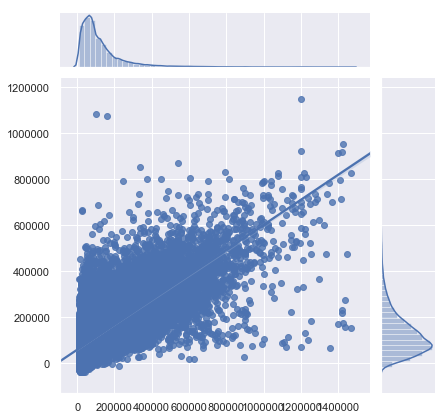

In [63]:
sns.jointplot(x=y_test, y=predictions, kind='reg')

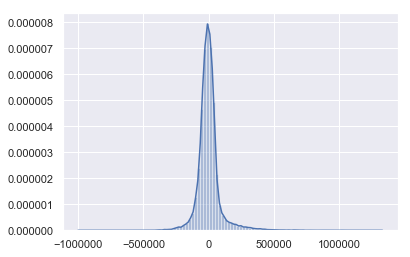

In [57]:
sns.distplot((y_test-predictions), bins=100)

In [58]:
np.sqrt(metrics.mean_squared_error(y_test, predictions))

89254.7992432107

In [59]:
for index, row in X_test[:10].iterrows():
    print(row)
    print(y_test[index])
    print(predictions[index])

document_type       Deed                                                
transaction_type    Purchase/Resale Arm's Length Residential Transaction
recording_year      2010                                                
recording_month     6                                                   
recording_day       16                                                  
contract_day        9                                                   
area_sqft           1343                                                
built_year          1951                                                
lot_size            5500                                                
no_of_baths         2                                                   
no_of_bedrooms      3                                                   
property_type       Single-Family Home                                  
tax_amount          3242.8                                              
Name: 0, dtype: object
99000.0
131463.6022499688
do

### Trying out predictions on external data

In [60]:
X_test.columns

Index(['document_type', 'transaction_type', 'recording_year',
       'recording_month', 'recording_day', 'contract_day', 'area_sqft',
       'built_year', 'lot_size', 'no_of_baths', 'no_of_bedrooms',
       'property_type', 'tax_amount'],
      dtype='object')

Test property: https://www.trulia.com/p/ny/binghamton/32-decatur-st-binghamton-ny-13903--2012602134

In [61]:
new_input = ['Deed', 'Insured Non-Residential Grant Deed', 2018, 7, 2, 23, 1503, 1960, 3000, 2, 3, 'Single-Family Home', 1225]

input_df = pd.DataFrame(data=[new_input], columns=X_test.columns)

In [62]:
outcome = pipeline.predict(input_df)
outcome

(1, 13)
(1, 60)


array([113431.31370496])